# Lecture 11 Demo: RNN

This demo is adapted from [this Pytorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).

## NLP From Scratch: Classifying Names with a Character-Level RNN


**Original Author**: [Sean Robertson](https://github.com/spro)  
*Modified by Drew Dimmery on 2024-04-22*

We will be building and training a basic character-level Recurrent
Neural Network (RNN) to classify words. This tutorial, along with two
other Natural Language Processing (NLP) \"from scratch\" tutorials
`/intermediate/char_rnn_generation_tutorial` and
`/intermediate/seq2seq_translation_tutorial`, show how to preprocess data to model NLP. In particular
these tutorials do not use many of the convenience functions of
`torchtext`, so you can see how preprocessing to model NLP
works at a low level.

A character-level RNN reads words as a series of characters -outputting
a prediction and \"hidden state\" at each step, feeding its previous
hidden state into each next step. We take the final prediction to be the
output, i.e. which class the word belongs to.

Specifically, we\'ll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

``` {.sourceCode .sh}
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

Recommended Readings
-----------------------

For some additional background on RNNs and how they work:

-   [The Unreasonable Effectiveness of Recurrent Neural
    Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
    shows a bunch of real life examples
-   [Understanding LSTM
    Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
    is about LSTMs specifically but also informative about RNNs in
    general

Preparing the Data
------------------

[Download the data from here](https://download.pytorch.org/tutorial/data.zip) and extract it to the current directory.

Included in the `data/names` directory are 18 text files named as
`[Language].txt`. Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We\'ll end up with a dictionary of lists of names per language,
`{language: [names ...]}`. The generic variables \"category\" and
\"line\" (for language and name in our case) are used for later
extensibility.

In [15]:
import utils as utils
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
print(utils.findFiles('dataRNN/names/*.txt'))

['dataRNN/names/Czech.txt', 'dataRNN/names/German.txt', 'dataRNN/names/Arabic.txt', 'dataRNN/names/Japanese.txt', 'dataRNN/names/Chinese.txt', 'dataRNN/names/Vietnamese.txt', 'dataRNN/names/Russian.txt', 'dataRNN/names/French.txt', 'dataRNN/names/Irish.txt', 'dataRNN/names/English.txt', 'dataRNN/names/Spanish.txt', 'dataRNN/names/Greek.txt', 'dataRNN/names/Italian.txt', 'dataRNN/names/Portuguese.txt', 'dataRNN/names/Scottish.txt', 'dataRNN/names/Dutch.txt', 'dataRNN/names/Korean.txt', 'dataRNN/names/Polish.txt']


In [20]:
print(utils.unicodeToAscii('Ślusàrski'))

fraction_test = 0.25

# Build the lines dictionary, a list of names per language
train_lines = {}
test_lines = {}
all_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [utils.unicodeToAscii(line) for line in lines]

for filename in utils.findFiles('dataRNN/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    n = len(lines)
    n_test = int(np.ceil(n * fraction_test))
    n_train = n - n_test
    in_test = np.random.permutation([True] * n_test + [False] * n_train)
    in_train = ~in_test
    train_lines[category] = [line for idx, line in enumerate(lines) if in_train[idx]]
    test_lines[category] = [line for idx, line in enumerate(lines) if in_test[idx]]
    all_lines[category] = lines

n_categories = len(all_categories)

Slusarski


Now we have `category_lines`, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
`all_categories` (just a list of languages) and `n_categories` for later
reference.


In [7]:
print(all_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [8]:
{k: len(v) for k, v in all_lines.items()}

{'Czech': 519,
 'German': 724,
 'Arabic': 2000,
 'Japanese': 991,
 'Chinese': 268,
 'Vietnamese': 73,
 'Russian': 9408,
 'French': 277,
 'Irish': 232,
 'English': 3668,
 'Spanish': 298,
 'Greek': 203,
 'Italian': 709,
 'Portuguese': 74,
 'Scottish': 100,
 'Dutch': 297,
 'Korean': 94,
 'Polish': 139}

Turning Names into Tensors
==========================

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a \"one-hot vector\" of size
`<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at
index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix
`<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we\'re just using a batch size of 1 here.


In [9]:
print(utils.letterToTensor('J'))

print(utils.lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very \"pure\" way,
as regular feed-forward layers.

This RNN module implements a \"vanilla RNN\" an is just 3 linear layers
which operate on an input and hidden state, with a `LogSoftmax` layer
after the output.


In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden)) #pass in dand update the hidden state 
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128 # just use it ! 
rnn = RNN(utils.N_LETTERS, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We\'ll get back the output (probability
of each language) and a next hidden state (which we keep for the next
step).


In [21]:
input = utils.letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don\'t want to be creating a new Tensor
for every step, so we will use `lineToTensor` instead of
`letterToTensor` and use slices. This could be further optimized by
precomputing batches of Tensors.


In [22]:
input = utils.lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(torch.exp(output))

tensor([[0.0560, 0.0609, 0.0528, 0.0568, 0.0549, 0.0511, 0.0464, 0.0550, 0.0552,
         0.0553, 0.0556, 0.0564, 0.0643, 0.0470, 0.0533, 0.0555, 0.0562, 0.0673]],
       grad_fn=<ExpBackward0>)


As you can see the output is a `<1 x n_categories>` Tensor, where every
item is the likelihood of that category (higher is more likely).


Training
========

Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use `Tensor.topk` to get the index
of the greatest value:


In [23]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Polish', 17)


We will also want a quick way to get a training example (a name and its
language):


In [24]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = utils.lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomTestExample():
    category = randomChoice(all_categories)
    line = randomChoice(test_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = utils.lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ name =', line)

category = Arabic / name = Nader
category = Portuguese / name = Matos
category = Arabic / name = Cham
category = Italian / name = Marchegiano
category = Irish / name = Dalach
category = Spanish / name = Garrastazu
category = Chinese / name = Yin
category = Greek / name = Gianakopulos
category = English / name = Ranger
category = English / name = Linley


Training the Network
====================

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it\'s wrong.

For the loss function `nn.NLLLoss` is appropriate, since the last layer
of the RNN is `nn.LogSoftmax`.


In [25]:
criterion = nn.NLLLoss() # just clasification ... log likelihood
optimizer = torch.optim.Adam(rnn.parameters(), lr=3e-4)

Each loop of training will:

-   Create input and target tensors
-   Create a zeroed initial hidden state
-   Read each letter in and
    -   Keep hidden state for next letter
-   Compare final output to target
-   Back-propagate
-   Return the output and loss


In [27]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden() # all zero 

    #rnn.zero_grad()
    optimizer.zero_grad()  # all zero 

    for i in range(line_tensor.size()[0]):   # letter by letter , any lenght possible
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    # for p in rnn.parameters():
    #     p.data.add_(p.grad.data, alpha=-learning_rate)
    optimizer.step()

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the `train`
function returns both the output and loss we can print its guesses and
also keep track of loss for plotting. Since there are 1000s of examples
we print only every `print_every` examples, and take an average of the
loss.


In [28]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 2s) 1.5026 Gwozdek / Polish ✓
10000 10% (0m 5s) 1.8852 Czabal / Arabic ✗ (Czech)
15000 15% (0m 8s) 0.4991 Ferreira / Portuguese ✓
20000 20% (0m 10s) 1.0462 Dang / Chinese ✗ (Vietnamese)
25000 25% (0m 13s) 0.2422 Tsangaris / Greek ✓
30000 30% (0m 15s) 0.7500 Otten / Dutch ✓
35000 35% (0m 18s) 0.1931 Lac / Vietnamese ✓
40000 40% (0m 21s) 0.0991 Mersinias / Greek ✓
45000 45% (0m 23s) 2.0454 Rios / Greek ✗ (Spanish)
50000 50% (0m 26s) 0.6405 Nazari / Arabic ✓
55000 55% (0m 28s) 0.0140 Karkampasis / Greek ✓
60000 60% (0m 31s) 0.1893 Di pietro / Italian ✓
65000 65% (0m 34s) 0.0792 Marshall / Scottish ✓
70000 70% (0m 36s) 0.0239 Doan / Vietnamese ✓
75000 75% (0m 39s) 1.5278 Pattison / Czech ✗ (English)
80000 80% (0m 41s) 0.0300 Davidson / Scottish ✓
85000 85% (0m 44s) 0.2714 Madeira / Portuguese ✓
90000 90% (0m 47s) 0.3526 Muir / Scottish ✓
95000 95% (0m 49s) 0.0916 Koemans / Dutch ✓
100000 100% (0m 52s) 0.3046 Siskind / German ✓


Plotting the Results
====================

Plotting the historical loss from `all_losses` shows the network
learning:


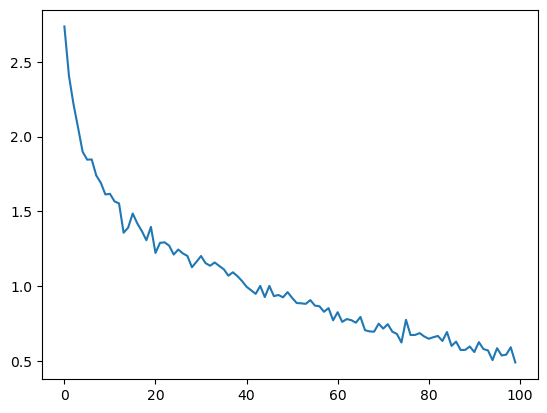

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with `evaluate()`,
which is the same as `train()` minus the backprop.


In [30]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTestExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

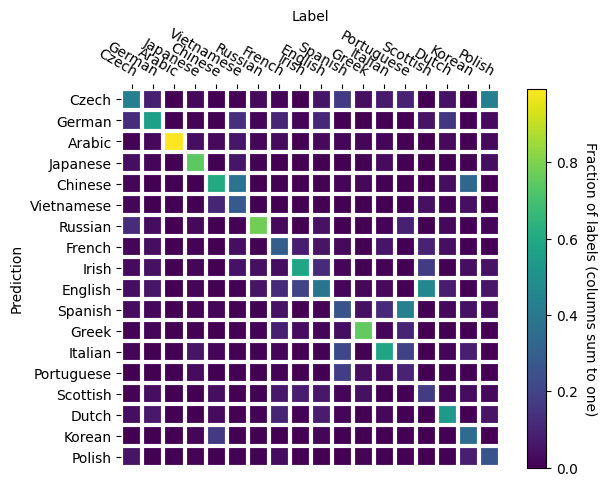

In [17]:
fig, ax = plt.subplots()
im, cbar = utils.heatmap(confusion.numpy().T, all_categories, all_categories, ax=ax,
                   cmap="viridis", cbarlabel="Fraction of labels (columns sum to one)")
#texts = utils.annotate_heatmap(im, valfmt="{x:.2f}", textcolors = ("grey", "black"), threshold = 0.3)

fig.tight_layout()
plt.xlabel("Label")
ax.xaxis.set_label_position('top') 
plt.ylabel("Prediction")
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).


Running on User Input
=====================


In [31]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(utils.lineToTensor(input_line))

        # Get top N categories
        topv, topi = torch.exp(output).topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Chekhov')
predict('Orwell')
predict('Munch')
predict('Schiele')
predict('Satoshi')
predict('Dimmery')


> Chekhov
(1.00) Russian
(0.00) Arabic
(0.00) Japanese

> Orwell
(0.51) English
(0.20) Czech
(0.17) Dutch

> Munch
(0.49) Scottish
(0.46) Irish
(0.02) English

> Schiele
(0.86) Dutch
(0.05) English
(0.04) German

> Satoshi
(0.75) Japanese
(0.21) Arabic
(0.03) Italian

> Dimmery
(0.78) Scottish
(0.21) English
(0.00) Irish
